## Import Libraries

In [219]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import dtale


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [220]:
df = pd.read_csv('final_data.csv')

In [221]:
dtale.show(df, open_browser=True)

In [3]:
df.shape

(10754, 22)

In [4]:
df.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [5]:
# uniqeness
df.duplicated().sum()

0

In [6]:
# Completeness
df.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [7]:
# Accurecy types
df.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [8]:
# drop column player we dont need it 
# drop column position becuse we have position_encoded
df.drop('player',axis=1,inplace = True) 
#df.drop('position',axis=1,inplace = True) 
df.dtypes

team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [10]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
# position is alrady encoded

categorical_features = ['team']
numeric_features = ['height', 'age', 'appearance','goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards',
       'goals conceded', 'clean sheets', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value',
       'position_encoded', 'winger']

       

In [11]:
for i in categorical_features:
    print (df[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64


In [12]:
for i in numeric_features:
    print(df[i].value_counts())


height
180.000000    744
185.000000    608
175.000000    596
178.000000    594
183.000000    572
188.000000    493
184.000000    458
182.000000    449
181.240353    440
186.000000    423
187.000000    419
176.000000    390
177.000000    372
190.000000    371
173.000000    366
179.000000    359
181.000000    355
170.000000    312
191.000000    272
174.000000    270
189.000000    255
172.000000    254
192.000000    203
193.000000    181
171.000000    169
168.000000    124
194.000000    117
169.000000    107
195.000000     98
167.000000     85
196.000000     68
166.000000     44
165.000000     42
197.000000     31
198.000000     24
163.000000     16
160.000000     15
164.000000     14
199.000000     12
200.000000     12
202.000000      6
162.000000      6
161.000000      3
206.000000      2
204.000000      1
156.000000      1
159.000000      1
Name: count, dtype: int64
age
22.000000    841
23.000000    823
26.000000    812
25.000000    772
24.000000    767
21.000000    715
28.000000    67

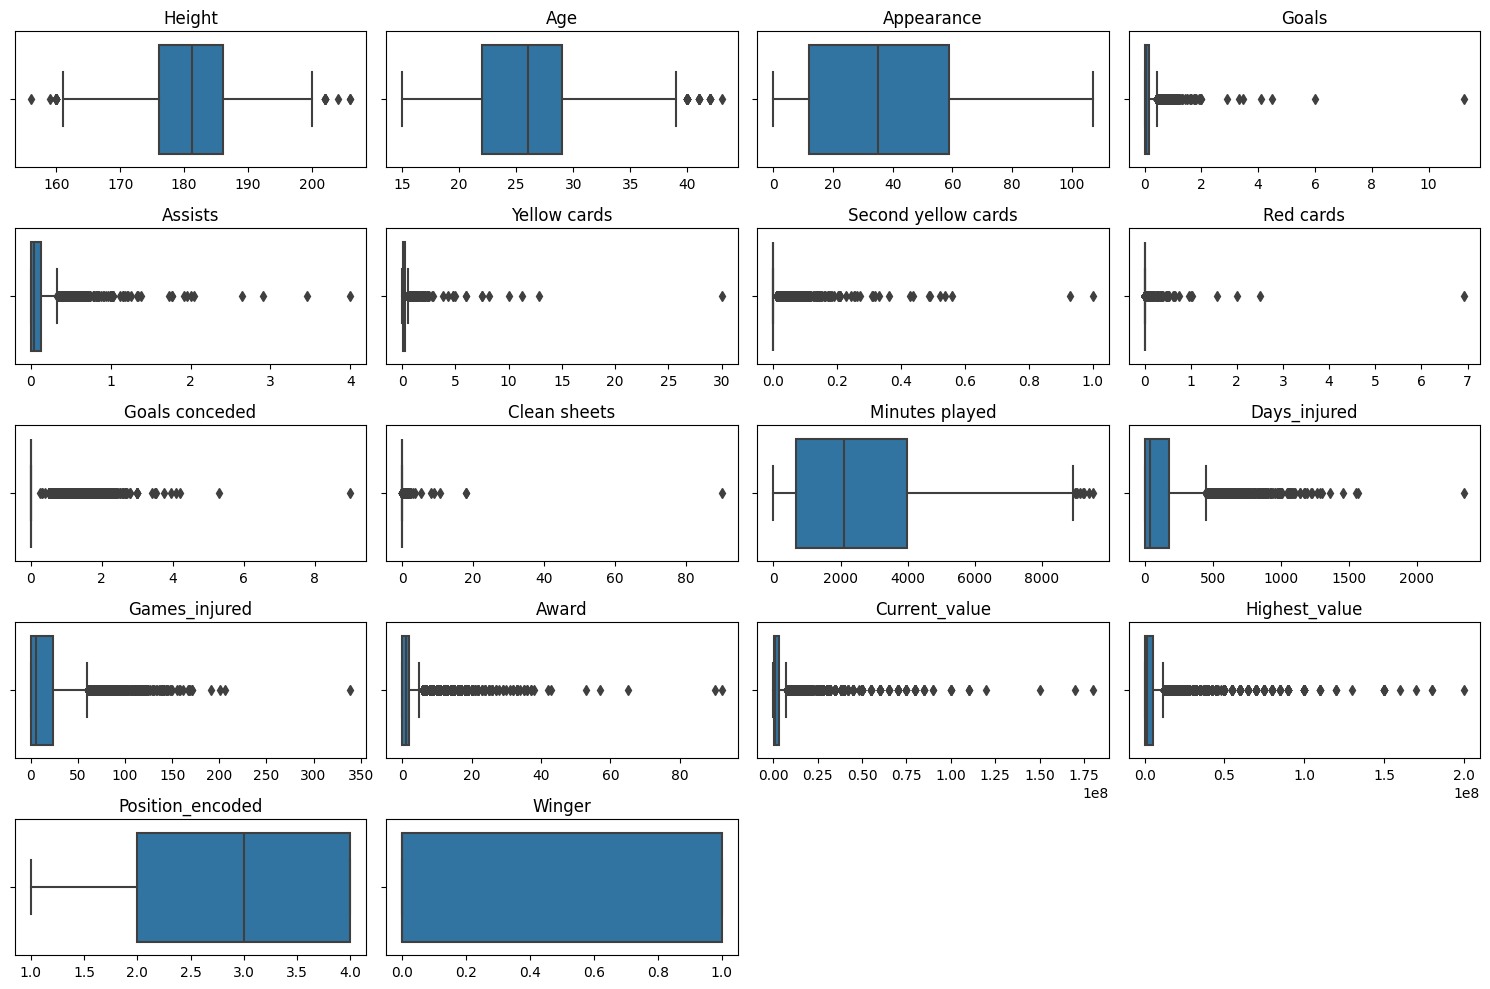

In [19]:
# boxplot for the feature 
num_features = len(numeric_features)

num_rows = math.ceil(num_features / 4)
num_cols = min(4, num_features)

plt.figure(figsize=(15, 10))

for i, column in enumerate(numeric_features, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=df[column])
    plt.title(column.capitalize())
    plt.xlabel('')

plt.tight_layout()
plt.show()


In [20]:
#removing outlier using the interquartile range (IQR) method
columns_to_analyze = df.drop(columns=['position_encoded', 'winger','position','name','team'])

def remove_outliers_iqr(df, columns_to_analyze):
   
    df_cleaned = df.copy()
    for column in columns_to_analyze:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    return df_cleaned

# Example usage:
cleaned_df = remove_outliers_iqr(df, columns_to_analyze)


In [21]:
print(cleaned_df.shape)
print(df.shape)

(4309, 21)
(10754, 21)


In [22]:
# Calculate the frequency of each 'Make'
make_counts = df['name'].value_counts()
make_counts


name
Paulinho              6
Vitinho               5
Guilherme             5
Fernando              4
João Pedro            4
                     ..
Everson               1
Matheus Mendes        1
Gabriel Delfim        1
Nathan Silva          1
Alexander Badolato    1
Name: count, Length: 10584, dtype: int64

In [23]:

fig = px.histogram(df, x='current_value', nbins=100, title='Histogram of Current Value')

fig.show()


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [24]:
df.head(2)

,team,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [25]:
categorical_features

['team']

In [26]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [27]:
df.shape

(10754, 394)

In [28]:
df.head(2)

,name,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,...,team_West Ham United,team_Western Sydney Wanderers,team_Western United FC,team_Wigan Athletic,team_Wolfsberger AC,team_Wolverhampton Wanderers,team_Yokohama F. Marinos,team_Yokohama FC,team_Zenit St. Petersburg,team_Ümraniyespor
0,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


#### 3. Feature selection

In [29]:
corr = df[numeric_features].corr()

# Create the heatmap using Plotly Express
fig = px.imshow(corr,
                text_auto=True,
                color_continuous_scale='RdBu',
                aspect='auto')
fig.show()


In [30]:

print(corr['current_value'].sort_values(ascending=False))

current_value          1.000000
highest_value          0.834553
minutes played         0.420542
appearance             0.419656
award                  0.300454
assists                0.137415
games_injured          0.135654
goals                  0.121574
days_injured           0.107686
position_encoded       0.085154
height                 0.040535
winger                 0.005034
red cards             -0.010171
clean sheets          -0.011684
yellow cards          -0.011766
second yellow cards   -0.013889
age                   -0.050156
goals conceded        -0.063529
Name: current_value, dtype: float64


In [31]:
# Set the correlation threshold
threshold = 0.12  

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = corr[abs(corr['current_value']) > threshold]['current_value'].index
selected_features

Index(['appearance', 'goals', 'assists', 'minutes played', 'games_injured',
       'award', 'current_value', 'highest_value'],
      dtype='object')

In [32]:
selected_features = ['appearance', 'goals', 'assists', 'minutes played', 'games_injured', 'award', 'current_value', 'highest_value']

In [33]:
df = df[selected_features]
df.head()

,appearance,goals,assists,minutes played,games_injured,award,current_value,highest_value
0,104,0.000000,0.000000,9390,5,13,15000000,70000000
1,15,0.000000,0.000000,1304,58,1,1500000,22000000
2,4,0.000000,0.000000,292,84,4,600000,6000000
3,82,0.028090,0.056180,6408,22,9,50000000,50000000
4,63,0.017889,0.017889,5031,51,21,40000000,80000000


#### 4. Prepare train and test data

In [34]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Buliding the Model

In [191]:
model = LinearRegression()

In [192]:

ridge_model = Ridge(alpha = 20)

In [193]:

lasso_model = Lasso(alpha = 8000)

In [185]:
param_grid = {
    'alpha': [10000, 8800, 7900, 8000, 14000, 15000]  # Regularization strength
}
grid_search = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [194]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

In [195]:

ridge_model.fit(X_train_scaled, y_train)

Ridge(alpha=20)

In [196]:

lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=8000)

In [197]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=Ridge(alpha=20),
             param_grid={'alpha': [10000, 8800, 7900, 8000, 14000, 15000]},
             scoring='neg_mean_squared_error', verbose=1)

In [198]:

grid_search_lasso.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=Lasso(alpha=5000),
             param_grid={'alpha': [10000, 8800, 7900, 8000, 14000, 15000]},
             scoring='neg_mean_squared_error', verbose=1)

## Test the Model

In [199]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

In [200]:

y_pred_ridge = ridge_model.predict(X_test_scaled)

In [201]:

y_pred_lasso = lasso_model.predict(X_test_scaled)

In [202]:

# Best hyperparameter
print("Best parameters found: ", grid_search.best_params_)

# Best model
best_ridge = grid_search.best_estimator_

Best parameters found:  {'alpha': 7900}


In [203]:
# Best hyperparameter
print("Best parameters found: ", grid_search_lasso.best_params_)

# Best model
best_ridge = grid_search_lasso.best_estimator_

Best parameters found:  {'alpha': 8000}


In [204]:

y_pred_ridge_cv = best_ridge.predict(X_test_scaled)

## Interpretation of the Model

In [217]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.222695e+06
goals,2.171102e+05
assists,1.912811e+05
minutes played,2.155161e+06
games_injured,-7.549591e+05
award,-1.703360e+06
highest_value,8.123261e+06


In [206]:
print(model.intercept_) 

3612928.704277743


In [207]:

coeff_df = pd.DataFrame(ridge_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.133872e+06
goals,2.122908e+05
assists,1.876492e+05
minutes played,2.076188e+06
games_injured,-7.517348e+05
award,-1.682486e+06
highest_value,8.086664e+06


In [208]:
coeff_df = pd.DataFrame(lasso_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
appearance,-1.044122e+06
goals,1.987138e+05
assists,1.747202e+05
minutes played,1.984517e+06
games_injured,-7.504103e+05
award,-1.684777e+06
highest_value,8.101991e+06


## Evaluating the Model 

1. Mean Square Error

In [209]:
#maby drop
y_base = [y_train.mean()] * len(y_test)

In [210]:
# base model = benchmark model
mse_base = mean_squared_error(y_test, y_base )
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error of base model: {mse_base}')
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error of base model: 93659743832820.34
Mean Squared Error for training: 20371134766662.414
Mean Squared Error for testing: 24601412843000.918


2. Mean Absolute Error

In [211]:
# base model = benchmark model
mse_base = mean_absolute_error(y_test, y_base )
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute  Error of base model: {mse_base}')
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute  Error of base model: 4482090.158130862
Mean Absolute Error for training: 2108188.3431896064
Mean Absolute Error for testing: 2224637.9901559646


3. Root Mean Squared  Error

In [213]:
# base model = benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared  Error of base model: 2117.0947447223193
Root Mean Squared Error for training: 4513439.350059155
Root Mean Squared Error for testing: 4959981.133331146


4. R Square

In [212]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.74236918413125
R Square for testing: 0.7373275271080357


#### Predictions vs. Real Values

In [216]:
predictions = model.predict(X_test_scaled)
#predictions

In [215]:
Real_Values = np.array(y_test)
#Real_Values

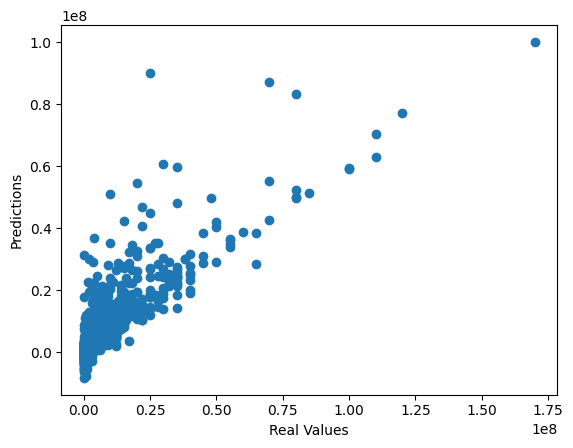

In [214]:
plt.scatter(Real_Values,predictions)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.show()

#### Residual Histogram

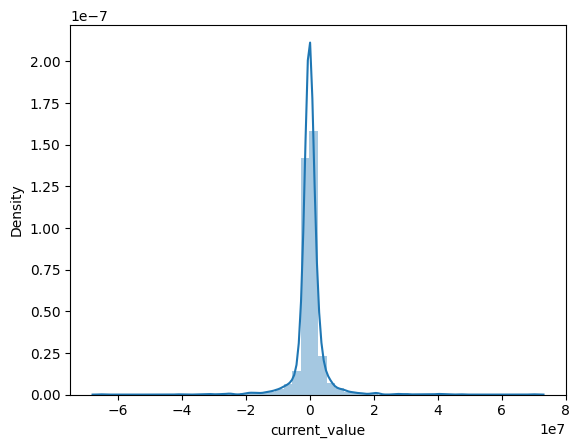

In [48]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution